In [39]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/LGD_Data_pass.xlsx')


### Preprocessing stage

In [3]:
# Quick data cleaning, dropped ranges for now
data = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
                  'lag_id_loan', 'delq_string', 'month_string'], axis=1)

In [4]:
# Treating NaN values
data.isnull().any()
data=data.dropna()

In [5]:
#Drop all the datetime columns for now
data.columns.to_series().groupby(data.dtypes).groups
data = data.drop(['Period', 'Dt_zero_BAL', 'Dt_Lst_Pi', 'prior_period', 'orign_qtr', 'dt_first_pi'], axis=1)

In [8]:
data

,ID_loan,delq_sts,loan_age,mths_remng,repch_flag,CD_Zero_BAL,New_Int_rt,Amt_Non_Int_Brng_Upb,MI_Recoveries,Net_Sale_Proceeds,...,int_rt,channel,ppmt_pnlty,prod_type,st,prop_type,loan_purpose,orig_loan_term,cnt_borr,LGD
0,F111Q1001064,0,99,462,N,3,4.750,0.0,0.0,122198.83,...,4.750,R,N,FRM,DE,SF,C,360,1,0.265
1,F111Q1004260,16,28,332,N,3,4.875,0.0,0.0,187270.40,...,4.875,C,N,FRM,NC,CO,N,360,1,0.162
2,F111Q1004580,2,27,333,N,3,5.250,0.0,30861.0,115008.58,...,5.250,R,N,FRM,WI,SF,N,360,1,0.000
3,F111Q1004663,10,18,342,N,3,4.375,0.0,73769.0,290071.21,...,4.375,C,N,FRM,MA,SF,N,360,1,0.057
4,F111Q1004665,10,17,343,N,3,5.125,0.0,0.0,336488.84,...,5.125,R,N,FRM,OH,SF,N,360,2,0.049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,F111Q2240130,15,36,324,N,3,4.750,0.0,0.0,206300.76,...,4.750,R,N,FRM,IL,SF,N,360,1,0.074
1051,F111Q2244003,0,95,265,N,3,5.375,0.0,0.0,21856.24,...,5.375,R,N,FRM,IL,SF,N,360,1,0.817
1052,F111Q2244349,13,29,331,N,3,5.375,0.0,0.0,15239.60,...,5.375,R,N,FRM,IL,SF,N,360,1,0.957
1053,F111Q2245120,42,53,247,N,3,5.125,0.0,0.0,181774.29,...,5.125,R,N,FRM,NY,SF,N,300,2,0.579


In [70]:
# Converting years and months
from IPython.display import clear_output
clear_output()
data['Period'] = pd.to_datetime(data['Period'], format='%Y%m')
data['Dt_zero_BAL'] = pd.to_datetime(data['Dt_zero_BAL'], format='%Y%m')
data['Dt_Lst_Pi'] = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m')
data['prior_period'] = pd.to_datetime(data['prior_period'], format='%Y%m')
data['dt_first_pi'] = pd.to_datetime(data['dt_first_pi'], format='%Y%m')
# Converting quarters 
intr = data['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()

### Gradient Boosting Regressor
The regressor uses RMSE as a loss function. This is the baseline model set to test the performance of the methods in question. The gridsearch of the hyperparameters has not been performed yet. 

The date-time variables have been dropped for now, yet they are to be considered in the future.

In [67]:
#Quick model
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds'], axis=1)
y = data['LGD']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)
# categorical features of the model
cat_features = ['loan_purpose', 'prop_type', 'st', 'prod_type', 'ppmt_pnlty', 'channel', 'occpy_sts', 'occpy_sts', 'flag_fthb',
               'CD_Zero_BAL']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)

#delq_string should be tranformed to list, month_string should be transformed to list of dates 
model = CatBoostRegressor(iterations=5000,
                          learning_rate=0.1,
                          eval_metric='R2',
                          logging_level='Silent',
                          depth=5)
# Fit model
model.fit(train_dataset, plot=True)
# Get predictions
preds = model.predict(test_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Model with GridSearch 

In contrast to grid search, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is specified in the n_iter parameter.

In [62]:
grid = {'learning_rate': [0.01, 0.03, 0.1, 0.2],
        'depth': [4, 6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

hyper_model = CatBoostRegressor()
randomized_search_result = hyper_model.randomized_search(grid,
                                                   X=train_dataset,
#                                                    y=y_train1,
                                                   plot=True)

# Fit model
hyper_model.fit(train_dataset, plot=True)
# Get predictions
preds = hyper_model.predict(test_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1904208	total: 9.37ms	remaining: 9.36s
1:	learn: 0.1797091	total: 15.7ms	remaining: 7.86s
2:	learn: 0.1716625	total: 26.4ms	remaining: 8.78s
3:	learn: 0.1655189	total: 36ms	remaining: 8.96s
4:	learn: 0.1600248	total: 44.1ms	remaining: 8.77s
5:	learn: 0.1551005	total: 52.7ms	remaining: 8.73s
6:	learn: 0.1516339	total: 59.7ms	remaining: 8.47s
7:	learn: 0.1481791	total: 65.8ms	remaining: 8.16s
8:	learn: 0.1451382	total: 74.7ms	remaining: 8.23s
9:	learn: 0.1426017	total: 82.4ms	remaining: 8.16s
10:	learn: 0.1398834	total: 89.7ms	remaining: 8.06s
11:	learn: 0.1382542	total: 95.5ms	remaining: 7.86s
12:	learn: 0.1370230	total: 102ms	remaining: 7.75s
13:	learn: 0.1347802	total: 109ms	remaining: 7.65s
14:	learn: 0.1332225	total: 117ms	remaining: 7.66s
15:	learn: 0.1315143	total: 125ms	remaining: 7.69s
16:	learn: 0.1295440	total: 133ms	remaining: 7.71s
17:	learn: 0.1278860	total: 140ms	remaining: 7.65s
18:	learn: 0.1267577	total: 148ms	remaining: 7.65s
19:	learn: 0.1252295	total: 156

185:	learn: 0.0304068	total: 1.4s	remaining: 6.11s
186:	learn: 0.0302839	total: 1.4s	remaining: 6.1s
187:	learn: 0.0301336	total: 1.41s	remaining: 6.08s
188:	learn: 0.0297839	total: 1.42s	remaining: 6.07s
189:	learn: 0.0296464	total: 1.42s	remaining: 6.07s
190:	learn: 0.0293987	total: 1.43s	remaining: 6.05s
191:	learn: 0.0292252	total: 1.44s	remaining: 6.04s
192:	learn: 0.0290624	total: 1.44s	remaining: 6.03s
193:	learn: 0.0289000	total: 1.45s	remaining: 6.03s
194:	learn: 0.0288040	total: 1.46s	remaining: 6.01s
195:	learn: 0.0286651	total: 1.46s	remaining: 6s
196:	learn: 0.0283977	total: 1.47s	remaining: 5.99s
197:	learn: 0.0281354	total: 1.48s	remaining: 5.98s
198:	learn: 0.0278506	total: 1.48s	remaining: 5.97s
199:	learn: 0.0277805	total: 1.49s	remaining: 5.96s
200:	learn: 0.0276198	total: 1.5s	remaining: 5.95s
201:	learn: 0.0275556	total: 1.5s	remaining: 5.94s
202:	learn: 0.0273882	total: 1.51s	remaining: 5.94s
203:	learn: 0.0268918	total: 1.52s	remaining: 5.94s
204:	learn: 0.026757

360:	learn: 0.0114683	total: 2.55s	remaining: 4.52s
361:	learn: 0.0114343	total: 2.56s	remaining: 4.51s
362:	learn: 0.0113101	total: 2.57s	remaining: 4.5s
363:	learn: 0.0112617	total: 2.57s	remaining: 4.5s
364:	learn: 0.0111593	total: 2.58s	remaining: 4.49s
365:	learn: 0.0110904	total: 2.58s	remaining: 4.48s
366:	learn: 0.0110413	total: 2.59s	remaining: 4.47s
367:	learn: 0.0110246	total: 2.6s	remaining: 4.46s
368:	learn: 0.0109880	total: 2.61s	remaining: 4.46s
369:	learn: 0.0109533	total: 2.61s	remaining: 4.45s
370:	learn: 0.0109000	total: 2.62s	remaining: 4.44s
371:	learn: 0.0108322	total: 2.63s	remaining: 4.43s
372:	learn: 0.0107852	total: 2.63s	remaining: 4.43s
373:	learn: 0.0107183	total: 2.64s	remaining: 4.42s
374:	learn: 0.0106961	total: 2.65s	remaining: 4.41s
375:	learn: 0.0106606	total: 2.65s	remaining: 4.4s
376:	learn: 0.0105675	total: 2.66s	remaining: 4.4s
377:	learn: 0.0105514	total: 2.67s	remaining: 4.39s
378:	learn: 0.0104745	total: 2.67s	remaining: 4.38s
379:	learn: 0.010

535:	learn: 0.0051748	total: 3.73s	remaining: 3.23s
536:	learn: 0.0051488	total: 3.74s	remaining: 3.22s
537:	learn: 0.0051382	total: 3.75s	remaining: 3.22s
538:	learn: 0.0050945	total: 3.75s	remaining: 3.21s
539:	learn: 0.0050792	total: 3.76s	remaining: 3.2s
540:	learn: 0.0050688	total: 3.77s	remaining: 3.2s
541:	learn: 0.0050618	total: 3.78s	remaining: 3.19s
542:	learn: 0.0050389	total: 3.78s	remaining: 3.18s
543:	learn: 0.0050098	total: 3.79s	remaining: 3.18s
544:	learn: 0.0050002	total: 3.8s	remaining: 3.17s
545:	learn: 0.0049725	total: 3.8s	remaining: 3.16s
546:	learn: 0.0049595	total: 3.81s	remaining: 3.15s
547:	learn: 0.0049352	total: 3.81s	remaining: 3.15s
548:	learn: 0.0049127	total: 3.82s	remaining: 3.14s
549:	learn: 0.0048938	total: 3.83s	remaining: 3.13s
550:	learn: 0.0048716	total: 3.84s	remaining: 3.13s
551:	learn: 0.0048530	total: 3.84s	remaining: 3.12s
552:	learn: 0.0048308	total: 3.85s	remaining: 3.11s
553:	learn: 0.0048127	total: 3.86s	remaining: 3.1s
554:	learn: 0.004

702:	learn: 0.0027394	total: 4.97s	remaining: 2.1s
703:	learn: 0.0027356	total: 4.98s	remaining: 2.09s
704:	learn: 0.0027290	total: 4.99s	remaining: 2.09s
705:	learn: 0.0027219	total: 5s	remaining: 2.08s
706:	learn: 0.0027108	total: 5s	remaining: 2.07s
707:	learn: 0.0026918	total: 5.01s	remaining: 2.07s
708:	learn: 0.0026855	total: 5.02s	remaining: 2.06s
709:	learn: 0.0026790	total: 5.02s	remaining: 2.05s
710:	learn: 0.0026738	total: 5.03s	remaining: 2.04s
711:	learn: 0.0026597	total: 5.04s	remaining: 2.04s
712:	learn: 0.0026569	total: 5.04s	remaining: 2.03s
713:	learn: 0.0026470	total: 5.05s	remaining: 2.02s
714:	learn: 0.0026444	total: 5.05s	remaining: 2.01s
715:	learn: 0.0026214	total: 5.06s	remaining: 2.01s
716:	learn: 0.0026099	total: 5.07s	remaining: 2s
717:	learn: 0.0026019	total: 5.07s	remaining: 1.99s
718:	learn: 0.0025950	total: 5.08s	remaining: 1.98s
719:	learn: 0.0025902	total: 5.08s	remaining: 1.98s
720:	learn: 0.0025799	total: 5.09s	remaining: 1.97s
721:	learn: 0.0025693	

882:	learn: 0.0015086	total: 6.15s	remaining: 815ms
883:	learn: 0.0015075	total: 6.16s	remaining: 808ms
884:	learn: 0.0015043	total: 6.16s	remaining: 801ms
885:	learn: 0.0014977	total: 6.17s	remaining: 794ms
886:	learn: 0.0014941	total: 6.18s	remaining: 787ms
887:	learn: 0.0014900	total: 6.18s	remaining: 780ms
888:	learn: 0.0014858	total: 6.19s	remaining: 773ms
889:	learn: 0.0014786	total: 6.2s	remaining: 766ms
890:	learn: 0.0014770	total: 6.2s	remaining: 759ms
891:	learn: 0.0014719	total: 6.21s	remaining: 752ms
892:	learn: 0.0014700	total: 6.21s	remaining: 745ms
893:	learn: 0.0014686	total: 6.22s	remaining: 738ms
894:	learn: 0.0014657	total: 6.23s	remaining: 731ms
895:	learn: 0.0014610	total: 6.23s	remaining: 724ms
896:	learn: 0.0014581	total: 6.24s	remaining: 717ms
897:	learn: 0.0014552	total: 6.25s	remaining: 710ms
898:	learn: 0.0014546	total: 6.25s	remaining: 703ms
899:	learn: 0.0014507	total: 6.26s	remaining: 696ms
900:	learn: 0.0014462	total: 6.27s	remaining: 688ms
901:	learn: 0.

In [65]:
print(hyper_model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'l2_leaf_reg': 1, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Unifor

In [68]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)

In [75]:
mean_squared_error(y_test1, preds)

0.020094595533324607

In [69]:
def adj_r2():
    return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))
print('Adjusted R^2', adj_r2())
print('R^2 of the model', r2)
print('RMSE of the model', rmse)

Adjusted R^2 0.31072455003195854
R^2 of the model 0.48970767792421244
RMSE of the model 0.14175540742181444


In [32]:
def adj_r2():
    return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))
print('Adjusted R^2', adj_r2())

0.7423303838726221


In [34]:
adj_r2()

0.7423303838726221

#### Results of the model

The results of the model suggests that the model explains most of the variance in the data, judging by the adjusted R^2, R^2 and RMSE. 

### Feature Importance

This section considers two distinct methods in calculating feature importance. 

* **Shap Values**: A vector $\nu$  with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).
* **PredictionValuesChange**: For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
* **LossFunctionChange**: The individual importance values for each of the input features (the default feature importances calculation method for ranking metrics). This type of feature importance can be used for any model, but is particularly useful for ranking models, where other feature importance types might give misleading results. For each feature the value represents the difference between the loss value of the model with this feature and without it. *Since it is computationally expensive to retrain the model without one of the features, this model is built approximately using the original model with this feature removed from all the trees in the ensemble.*

Last two are calculated for training and testing sets. Both are of great importance since: 
1. The use of training set allows to assess how much the model relies on each feature for making predictions
2. The use of testing set allows to evaluate how much the feature contributes to the performance of the model on unseen data 

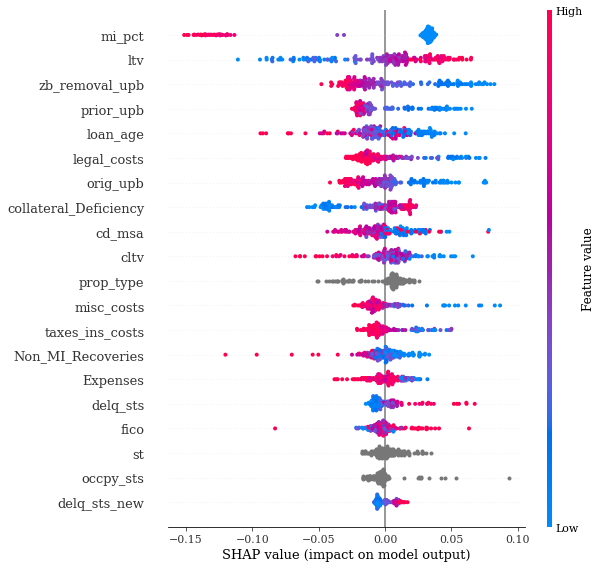

In [53]:
# Starting with Shap Values. Calculating each single contribution
import shap
shap_values = model.get_feature_importance(test_dataset, type="ShapValues")

shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test1) 

In [54]:
# matplotlib settings
import matplotlib as mpl
plt.style.use(['seaborn-bright'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})

%matplotlib inline

In [41]:

from sklearn import metrics


def get_feature_imp_plot(method):
    
#     if method == "Permutation":
#         fi =  permutation_importances(model, X_test1, y_test1, log_loss)
    
#     elif method == "Baseline":
#         fi = baseline_importance(model, X_train1, y_train1, X_test1, y_test1, log_loss)
    
#     elif method == "ShapeValues":
#         shap_values = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
#                                                                      type="ShapValues")
#         shap_values = shap_values[:,:-1]
#         shap.summary_plot(shap_values, X_test) 
        
#     else:
    fi = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Testing set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

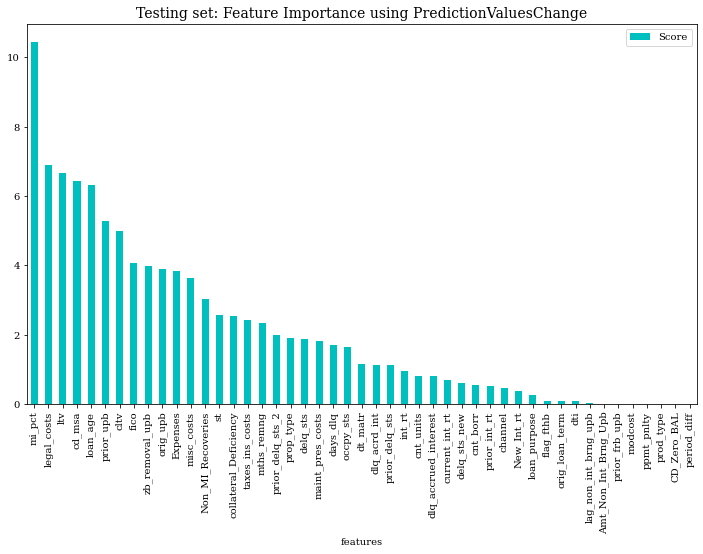

In [55]:
get_feature_imp_plot(method="PredictionValuesChange")

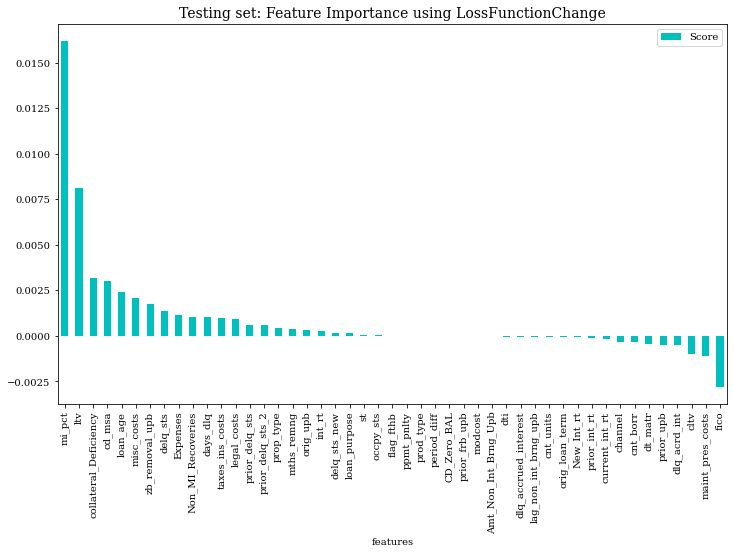

In [56]:
get_feature_imp_plot(method="LossFunctionChange")

In [73]:
def get_feature_imp_plot_train(method):
    

    fi = model.get_feature_importance(Pool(X_train1, label=y_train1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_train1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Training set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

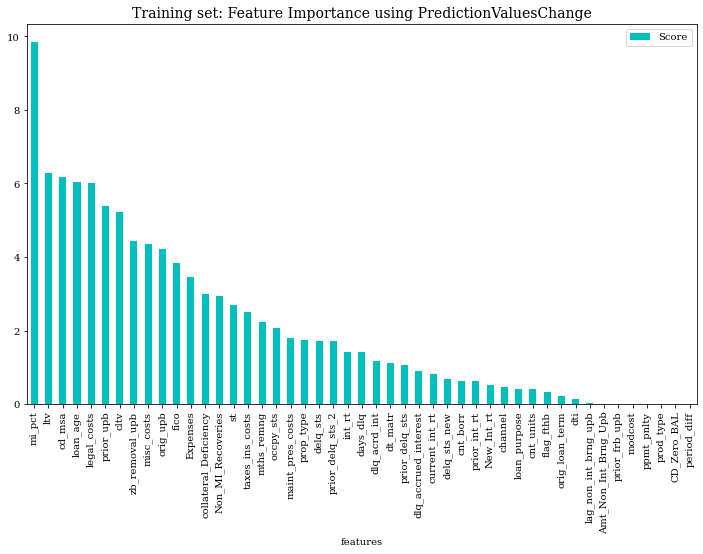

In [74]:
get_feature_imp_plot_train(method="PredictionValuesChange")

In [71]:
get_feature_imp_plot_train(method="LossFunctionChange")

NameError: name 'get_feature_imp_plot_train' is not defined

In [105]:
# Check the error distribution and then minimise the Huber function

# model_huber = CatBoostRegressor(iterations=1000,
#                           learning_rate=1,
#                           logging_level='Silent',
#                           loss_function='Huber',
#                           depth=2)


# # Fit model
# model_huber.fit(train_dataset, plot=True)
# # Get predictions
# preds_huber = model.predict(test_dataset)
clear_output()